In [15]:
import lxml.html as lh
import pandas as pd
import html2text
import re
import plotly.graph_objects as go
import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from wavelength_color import wavelength_to_rgb

In [16]:
file = open("PrincipleLanthanideTransitions.txt","r", encoding="utf-8")
doc = file.readlines()

In [17]:
headers = []
h = html2text.HTML2Text()
# Ignore converting links from HTML
h.ignore_links = True
for line in doc[11:19]:
    actual_text = h.handle(line)
    actual_text = actual_text.strip()
    actual_text = actual_text.strip("|")
    actual_text = actual_text.strip()
    headers.append(actual_text)
print(headers)

['Ln', 'Ground state', 'Excited state', 'Final state', 'Emission wavelength (nm)', 'Energy (cm−1)', 'Intensity', 'Remarks']


In [18]:
info = []
for line in doc[23:]:
    actual_text = h.handle(line)
    actual_text = actual_text.strip()
    actual_text = actual_text.strip("|")
    actual_text = actual_text.replace("![\\[thin space\n\\(1/6-em\\)\\]](https://www.rsc.org/images/entities/char_2009.gif)","")
    actual_text = actual_text.replace("![\\[thin\nspace \\(1/6-em\\)\\]](https://www.rsc.org/images/entities/char_2009.gif)","")
    actual_text = actual_text.strip()
    if actual_text != "":
        info.append(actual_text)
#print(info)
#print(len(info))

In [19]:
i = 0

lanthanides = {}
while i < len(info):
    #Check for element symbol
    if info[i][0].isupper() and info[i][1].islower() and len(info[i]) == 2:
        #Grab that element!
        current_lanthanide = info[i]
        lanthanides[current_lanthanide] = {'Transition': [], headers[4]: [], headers[5]: [], headers[6]: [], headers[7]: []}
        i += 1
        
        #Grab that ground state!
        ground_state = info[i]
        i += 1
        
    if "→" in info[i]:
        #Grab that excited state!
        excited_state = info[i]
        i += 1
    
        #Grab that final state!
        final_state = info[i]
        
        transition = excited_state + ' ' + final_state
        lanthanides[current_lanthanide]['Transition'].append(transition)
        lanthanides[current_lanthanide]['Emission wavelength (nm)'].append(info[i+1])
        lanthanides[current_lanthanide]['Energy (cm−1)'].append(info[i+2])
        lanthanides[current_lanthanide]['Intensity'].append(info[i+3])
        lanthanides[current_lanthanide]['Remarks'].append(info[i+4])
        i += 5
            
    else:
        #Grab that final state!
        final_state = info[i]
        
        transition = excited_state + ' ' + final_state
        lanthanides[current_lanthanide]['Transition'].append(transition)
        lanthanides[current_lanthanide]['Emission wavelength (nm)'].append(info[i+1])
        lanthanides[current_lanthanide]['Energy (cm−1)'].append(info[i+2])
        lanthanides[current_lanthanide]['Intensity'].append(info[i+3])
        lanthanides[current_lanthanide]['Remarks'].append(info[i+4])
        
        i += 5
    df = pd.DataFrame(lanthanides[current_lanthanide])

In [20]:
df = {}
for key in lanthanides:
    print(key)
    df[key] = pd.DataFrame(lanthanides[key])
    print(df[key])
#print(df)

Pr
  Transition Emission wavelength (nm) Energy (cm−1) Intensity    Remarks
0  3P2 → 3H4                      440         22727      Weak         QC
1  3P1 → 3H4                      470         21277      Weak         QC
2  3P1 → 1G4                      872         11468    Medium         QC
3  3P0 → 3H4                      480         20833    Strong  UC and QC
4  3P0 → 3H5                      545         18349      Weak  UC and QC
5  3P0 → 3H6                      606         16502    Medium  UC and QC
6  3P0 → 3F2                      640         15625      Weak  UC and QC
7  1D2 → 3F4                     1037          9643    Medium         QC
Nd
       Transition Emission wavelength (nm) Energy (cm−1)       Intensity  \
0   4D3/2 → 4I9/2                      355         28169            Weak   
1   2P3/2 → 4I9/2                      380         26316            Weak   
2  2P3/2 → 4I11/2                      410         24390          Strong   
3  2P3/2 → 4I13/2                

In [21]:
#Let's make some widgets!
widget_list = []
for key in lanthanides:
    #This will be a multi-select list of the transitions for that lanthanide.
    widget_info = widgets.SelectMultiple(
        options=[lanthanides[key]['Transition'][i] for i in range(len(lanthanides[key]['Transition']))],
        value=[],
        #rows=10,
        description='Transitions',
        disabled=False
    )
    #This will be the Select All Checkbox if we care about all of the transitions.
    lanthanide_select_all = widgets.Checkbox(
    value=False,
    description= key + ' Select All',
    disabled=False
    )
    container = widgets.HBox(children=[lanthanide_select_all,widget_info])
    widget_list.append(container)

In [22]:
tab_contents = [key for key in lanthanides]
children = widget_list
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, tab_contents[i])

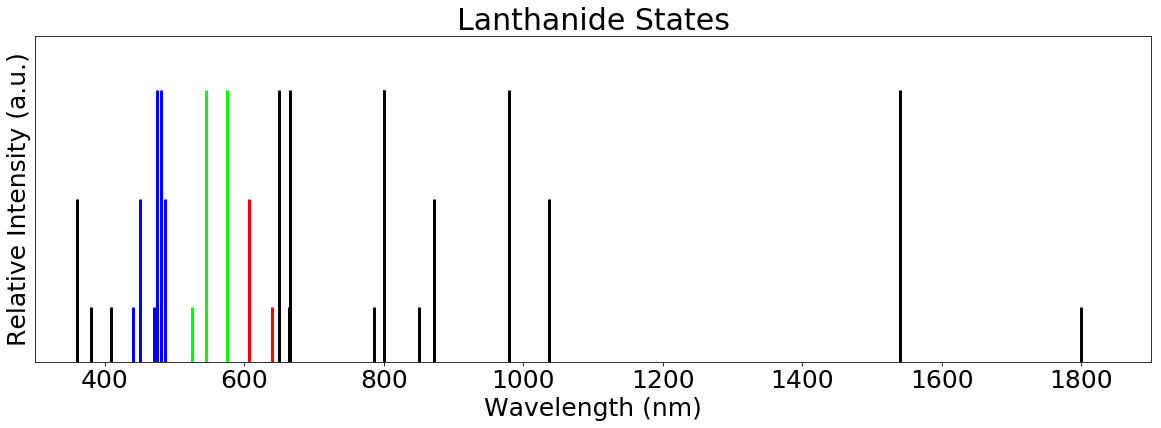

In [30]:
def update():
#If any 'select all' boxes are checked, update the tab view to reflect that then
#Grab list of selected states so that these can eventually be plotted
    box_ticks = [tab.children[k].children[0].value for k in range(len(tab_contents))]
    if any(box_ticks):
        for j in range(len(box_ticks)):
            if box_ticks[j]:
                tab.children[j].children[1].value = tab.children[j].children[1].options
    #Let's clear what we plotted previously so that we can update via appending
    lanthanide_x = []
    lanthanide_y = []
    #Look through all of those lanthanides!
    for z in range(len(tab_contents)):
        #Look through all of those transitions!
        for transition in children[z].children[1].value:
            element_data = df[tab_contents[z]]
            #Match the selected transitions with the tabulated data, so that we can grab that data (wavelength and intensity)
            if transition in element_data['Transition'].values:
                transition_index = element_data[element_data['Transition'] == transition].index.values
                intensity = element_data['Intensity'][transition_index].values
                #Grab intensity information
                if intensity == 'Strong':
                    intensity_value = 5
                elif intensity == 'Weak':
                    intensity_value = 1
                else:
                    intensity_value = 3
                #Grab wavelength information
                wavelength = element_data['Emission wavelength (nm)'][transition_index].values[0]
                if '-' in wavelength:
                    wavelength_start = int(wavelength.split('-')[0])
                    lanthanide_x.append(wavelength_start)
                    lanthanide_y.append(intensity_value)
                    wavelength_end = int(wavelength.split('-')[1])
                    lanthanide_x.append(wavelength_end)
                    lanthanide_y.append(intensity_value)
                elif '–' in wavelength:
                    wavelength_start = int(wavelength.split('–')[0])
                    lanthanide_x.append(wavelength_start)
                    lanthanide_y.append(intensity_value)
                    wavelength_end = int(wavelength.split('–')[1])
                    lanthanide_x.append(wavelength_end)
                    lanthanide_y.append(intensity_value)
                else:
                    wavelength = int(wavelength)
                    lanthanide_x.append(wavelength)
                    lanthanide_y.append(intensity_value)
    return lanthanide_x, lanthanide_y
    

fig = plt.figure(figsize=(20, 6))
#creating a subplot 
ax1 = fig.add_subplot(1,1,1)
ax1.axis([300, 1900, 0, 6])
plt.yticks([])
ax1.set(xlabel='Wavelength (nm)', ylabel='Relative Intensity (a.u.)',
       title='Lanthanide States')
plt.rcParams.update({'font.size': 25})
x_values, y_values = update()
for k in range(len(x_values)):
    ax1.vlines(x = x_values[k], ymin = 0, ymax = y_values[k], colors = wavelength_to_rgb(x_values[k]), linewidths = 3)
plt.show()
tab